In [204]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics

pd.set_option('display.max_rows', 10)

In [205]:
df_raw = pd.read_csv("../data/petfinder-adoption-prediction/train/train.csv")
df_raw.columns = df_raw.columns.str.lower() #make column names lowercase

In [206]:
df_raw.head().T

,0,1,2,3,4
type,2,2,1,1,1
name,Nibble,No Name Yet,Brisco,Miko,Hunter
age,3,1,1,4,1
breed1,299,265,307,307,307
breed2,0,0,0,0,0
...,...,...,...,...,...
videoamt,0,0,0,0,0
description,Nibble is a 3+ month old ball of cuteness. He ...,I just found it alone yesterday near my apartm...,Their pregnant mother was dumped by her irresp...,"Good guard dog, very alert, active, obedience ...",This handsome yet cute boy is up for adoption....
petid,86e1089a3,6296e909a,3422e4906,5842f1ff5,850a43f90
photoamt,1.0,2.0,7.0,8.0,3.0


In [207]:
# #eda_report = ProfileReport(df_raw, title="Eda report")
# eda_report.to_file("eda_report.html")

# Creates initial basic EDA report. Basically an increased .describe() and .info()

In [208]:
df_dropped = df_raw.drop(["state","petid","rescuerid","name"],axis=1) # Drop some columns that are not needed (yet)


In [209]:
df_dropped.adoptionspeed.value_counts(normalize=True) #Distribution of our classes. Relatively balanced! 
# Class 0 (Adopted on day of listing) will later be merge into class 1 (Adopted within the first week) since there are only few instances and for our stakeholder it is not so important.
# Also it is unlikely that pets with certain properties are predictably adopted on day 1 (instead of day 2-7). Its more likely that it is just by chance.

adoptionspeed
4    0.279931
2    0.269259
3    0.217368
1    0.206096
0    0.027346
Name: proportion, dtype: float64

In [210]:
#pd.crosstab([df_dropped["color1"],df_dropped["color2"],df_dropped["type"]],df_dropped["adoptionspeed"],normalize="index")

# Delete this?

In [211]:
for column_name in df_dropped.columns:
    print(pd.crosstab(df_dropped[column_name], df_dropped["adoptionspeed"],normalize="index"))
    print("____________")

# All features two-way influence on the target. There are some patterns but there are no clear and easy univariate ways to determine the adoption speed.
# 
# A few questions and feature engineering ideas arose:
# Some patterns we find might be different for cats and dogs.
# Check if a pure-breed vs mixed breed feature can be created
# Shall we bin the age to get rid of the outliers?
# The quantity column is tricky. If there are more animals listed in one profile (at a certain point) the adoption speed will decrease because it takes time until they all are adopted. 
# However, dropping all rows with quantity > 1 would mean that we loose 23% of data and would alter the age distribution (many profiles of quantity > 1 animals are newborn litters with very low age).
# Speaking of age: There seem to be many interactive effects with age. For example we thought that vaccinated and dewormed animals would have a higher adoption speed. That did not hold true, though, sine young animals have high adoption rate but are often not (yet) vaccinated.


adoptionspeed         0         1         2         3         4
type                                                           
1              0.020905  0.176463  0.266109  0.239670  0.296852
2              0.034980  0.241218  0.272992  0.190934  0.259875
____________
adoptionspeed         0         1         2         3         4
age                                                            
0              0.055866  0.279330  0.245810  0.217877  0.201117
1              0.023438  0.279080  0.327257  0.221788  0.148438
2              0.032829  0.246931  0.319726  0.223523  0.176991
3              0.022380  0.207528  0.298067  0.232960  0.239064
4              0.021641  0.190261  0.238954  0.234445  0.314698
..                  ...       ...       ...       ...       ...
168            0.000000  0.000000  0.000000  1.000000  0.000000
180            0.000000  0.000000  0.000000  0.500000  0.500000
212            0.000000  0.000000  0.000000  0.666667  0.333333
238            0.000000  0.

In [212]:
pd.crosstab(df_dropped.quantity, df_dropped.adoptionspeed)#, normalize="index")

adoptionspeed,0,1,2,3,4
quantity,,,,,
1,331,2439,3163,2552,3080
2,35,290,362,307,428
3,20,158,181,148,219
4,13,106,129,97,186
5,7,42,90,65,129
...,...,...,...,...,...
15,0,1,0,1,2
16,0,0,2,0,1
17,0,0,2,1,0


In [213]:
df_color_breed = df_dropped[["color1", "color2", "color3", "breed1", "breed2", "type"]]

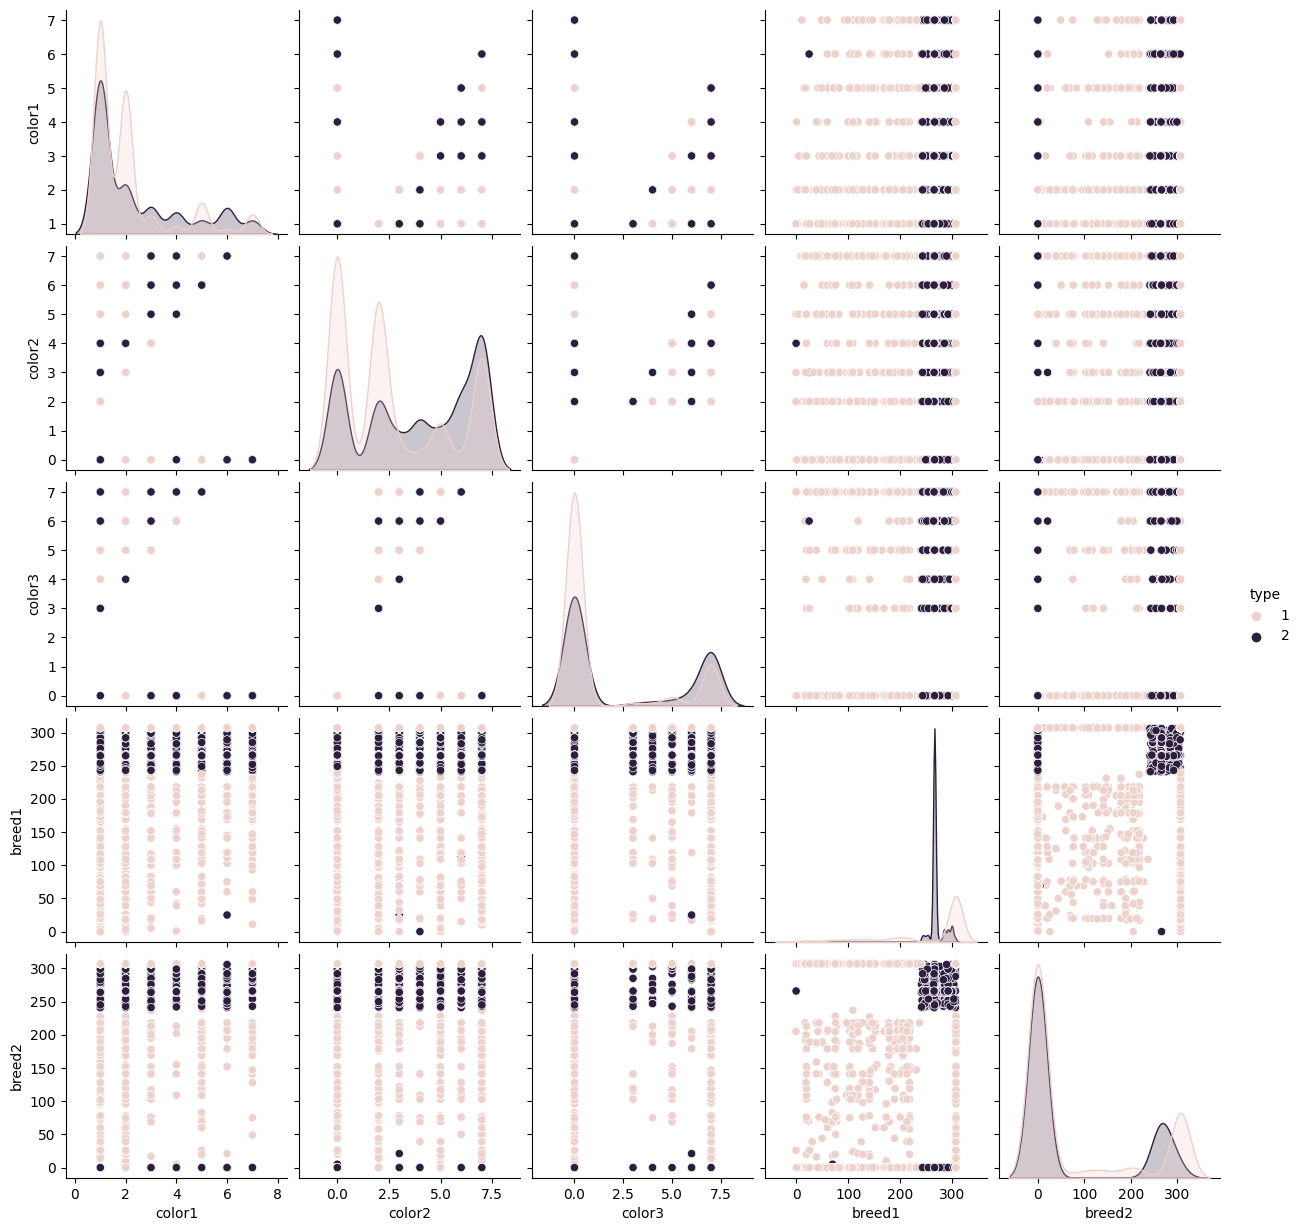

In [214]:
sns.pairplot(df_color_breed, hue="type")
# If an animal has the color black (1), the colorcode (1) is always used in the color1 column. Or generally for a multi-color animal the lowest colorcode goes into column1. This explains the triangular shapes below. 

color feature is filled in in numerical order: color1 < color2 < color3 (except for 0), not sorted by primary color
dark: (color1,color2,color3)= (1,0,0), (2,0,0), (6,0,0), (1,2,0), (1,6,0), (1,2,6), (2,6,0)
mixed: else
light: (3,0,0), (4,0,0), (5,0,0), (7,0,0), (3,4,0), (3,5,0), (3,7,0), (3,4,5), (3,4,7), (3,5,7), (4,5,0), (4,5,7), (4,7,0), (5,7,0)

1,"Black"
2,"Brown"
3,"Golden"
4,"Yellow"
5,"Cream"
6,"Gray"
7,"White"

breed: mixed breed/no breed 2 dominant, supporting the idea of mixed vs. pure breed feature (stumpy tail breed not in data set)
cat mixed breed: domestic short hair, domestic medium hair, domestic long hair are considered mixed breeds, breed1=!breed2
dog mixed breed: category 307 or different entries in breed1 and breed2 column. Pure breed: entry =!307 in breed 1 and breed2=0


# Idea to create color_pattern column encoding whether an animal is 'dark', "light" or "mixed" colored.

In [215]:
patternlist = []
for colorcode in (df_dropped.color1.astype(str) + df_dropped.color2.astype(str) + df_dropped.color3.astype(str)):
    if colorcode in ("100","200","600","120","160","126","260"):
        patternlist.append(0) # 0 = dark color pattern
    elif colorcode in ("300", "400", "500", "700", "340", "350", "370", "345", "347", "357", "450", "457", "470", "570"):
        patternlist.append(1) # 1 = light color pattern
    else:
        patternlist.append(2) # 2 = mixed color pattern

df_dropped["color_pattern"] = patternlist

In [216]:
df_dropped[["color_pattern"]].value_counts()

color_pattern
2                7533
0                4598
1                2862
Name: count, dtype: int64

In [217]:
pd.crosstab(df_dropped["color_pattern"],df_dropped["adoptionspeed"],normalize='index')
#pd.crosstab([df_dropped["color_pattern"],df_dropped["type"]],df_dropped["adoptionspeed"],normalize='index')
# mixed > light > black animals adoptionspeed. Only true for dogs, though. Presumably because black/dark dogs are intimidating

adoptionspeed,0,1,2,3,4
color_pattern,,,,,
0,0.021966,0.184211,0.271205,0.225968,0.296651
1,0.026904,0.241090,0.268344,0.205101,0.258560
2,0.030798,0.206160,0.268419,0.216780,0.277844


# Create pure-breed vs mixed breed feature

In [218]:
#df_dropped.breed2.value_counts()

In [219]:
# breed: mixed breed/no breed 2 dominant, supporting the idea of mixed vs. pure breed feature (stumpy tail breed not in data set)
# cat mixed breed: domestic short hair, domestic medium hair, domestic long hair are considered mixed breeds, breed1=!breed2
# dog mixed breed: category 307 or different entries in breed1 and breed2 column. Pure breed: entry =!307 in breed 1 and breed2=0

#264,2,"Domestic Long Hair"
#265,2,"Domestic Medium Hair"
#266,2,"Domestic Short Hair"

#pure_bred: breed2=0 & breed1 != 307, 264, 265, 266



In [220]:
df_dropped.query('breed1 == breed2 and breed1 != 307 and breed1 != 264 and breed1 != 265 and breed1 != 266').breed1.value_counts()

# There are some instances where pure bred animals have the same entry in breed1 and breed2 column. This needs to be taken into account.    

breed1
179    10
292     9
299     8
243     8
205     8
       ..
270     1
152     1
19      1
267     1
303     1
Name: count, Length: 43, dtype: int64

In [221]:
df_dropped['breed_type'] = np.where((((df_dropped["breed2"] == 0) | (df_dropped["breed1"] == df_dropped["breed2"])) & (df_dropped.breed1 != 307) & (df_dropped.breed1 != 264) & (df_dropped.breed1 != 265) & (df_dropped.breed1 != 266)), 0, 1)

# Complicated but it works :) 0 = pure-bred 1 = mixed-bred

In [222]:
df_dropped.breed_type.value_counts()

breed_type
1    12850
0     2143
Name: count, dtype: int64

<Axes: xlabel='adoptionspeed'>

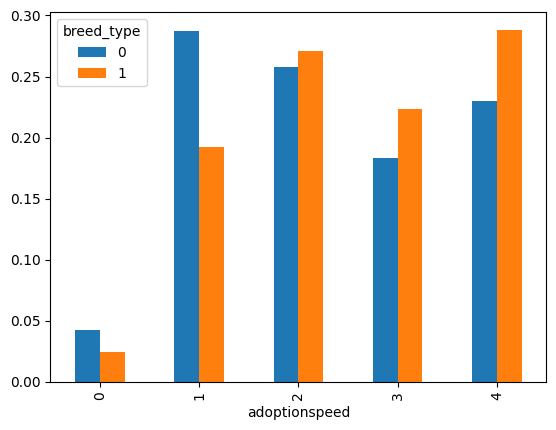

In [223]:
#we can use this graph in the presentation but separately for cats and dogs 

pd.crosstab(df_dropped["adoptionspeed"],df_dropped["breed_type"],normalize="columns").plot.bar()

# Pure-bred animals have a faster adoption speed.
# However, ...

In [224]:
pd.crosstab([df_dropped.type, df_dropped.breed_type], df_dropped.adoptionspeed,normalize='index')

# ... this is only true for dogs and quite the opposite for cats!

adoptionspeed           0         1         2         3         4
type breed_type                                                  
1    0           0.046193  0.317365  0.278015  0.204448  0.153978
     1           0.016659  0.152808  0.264110  0.245584  0.320839
2    0           0.037988  0.250513  0.233060  0.157084  0.321355
     1           0.034483  0.239681  0.279599  0.196535  0.249703

In [225]:
# 3 means not known and we replaced it with 2 that is not vaccinated or dewormed. Unknown vaccination status means that they need to get vaxxed anyways so its equal to "no vaccination"
df_dropped['vaccinated'] = df_dropped['vaccinated'].replace(3,2)
df_dropped['dewormed'] = df_dropped['dewormed'].replace(3,2)

In [226]:
# combine the vaccinated and dewormed pets and turn it into another feature. Vaccinated and dewormed are highly correlated and it most likely makes sense to only keep one.
# three categories: fully vaccinated and dewormed (0), either only vaccinated or dewormed (1), and neither vaccinated or dewormed (2) 

# create a list of our conditions
conditions = [
    ((df_dropped['vaccinated'] == 1) & (df_dropped['dewormed'] == 1)),
    ((df_dropped['vaccinated'] == 1) & (df_dropped['dewormed'] == 2)),
    ((df_dropped['vaccinated'] == 2) & (df_dropped['dewormed'] == 1)),
    ((df_dropped['vaccinated'] == 2) & (df_dropped['dewormed'] == 2))
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df_dropped['vaccinated_dewormed'] = np.select(conditions, values)

In [227]:
df_dropped['vaccinated_dewormed'].value_counts()

vaccinated_dewormed
2    6332
0    5634
1    3027
Name: count, dtype: int64

This new feature vaccinated_dewormed shows that adoption speed is not drastically effected by it that much, but this needs to be further investigated. But this is an important feature for further analysis as they both were highly correlated too. 

<Axes: xlabel='adoptionspeed'>

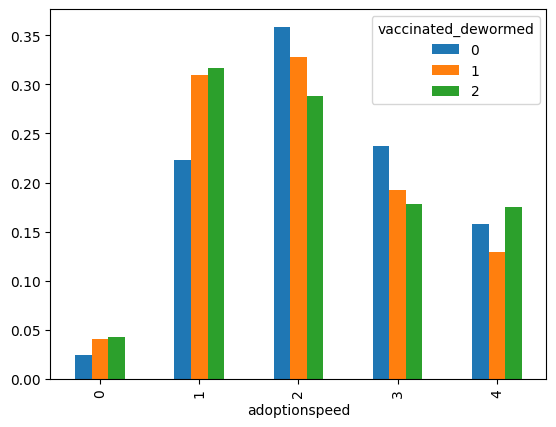

In [228]:
pd.crosstab(df_dropped.query('age < 4 & type == 2')['adoptionspeed'],df_dropped.query('age < 4 & type == 2')["vaccinated_dewormed"],normalize="columns").plot.bar()

# Age


In [229]:
# due to a very low number of instances in adoption speed 0, we will combine cat. 0 and 1
df_dropped.adoptionspeed = df_dropped.adoptionspeed.replace(0,1)

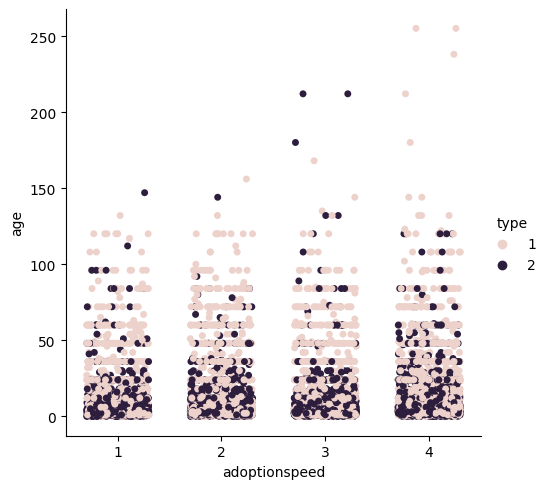

In [230]:
sns.catplot(data=df_dropped, x='adoptionspeed', y='age', hue='type', jitter=0.3)

hypothesis: cats will be adopted faster, regardless of their age, but old dogs will remain in the shelter longer. 
- younger animals are adopted faster
- there are more dogs then cats among the older animals in the shelter (adult or old dogs are in the shelter more frequently then adult or old cats)

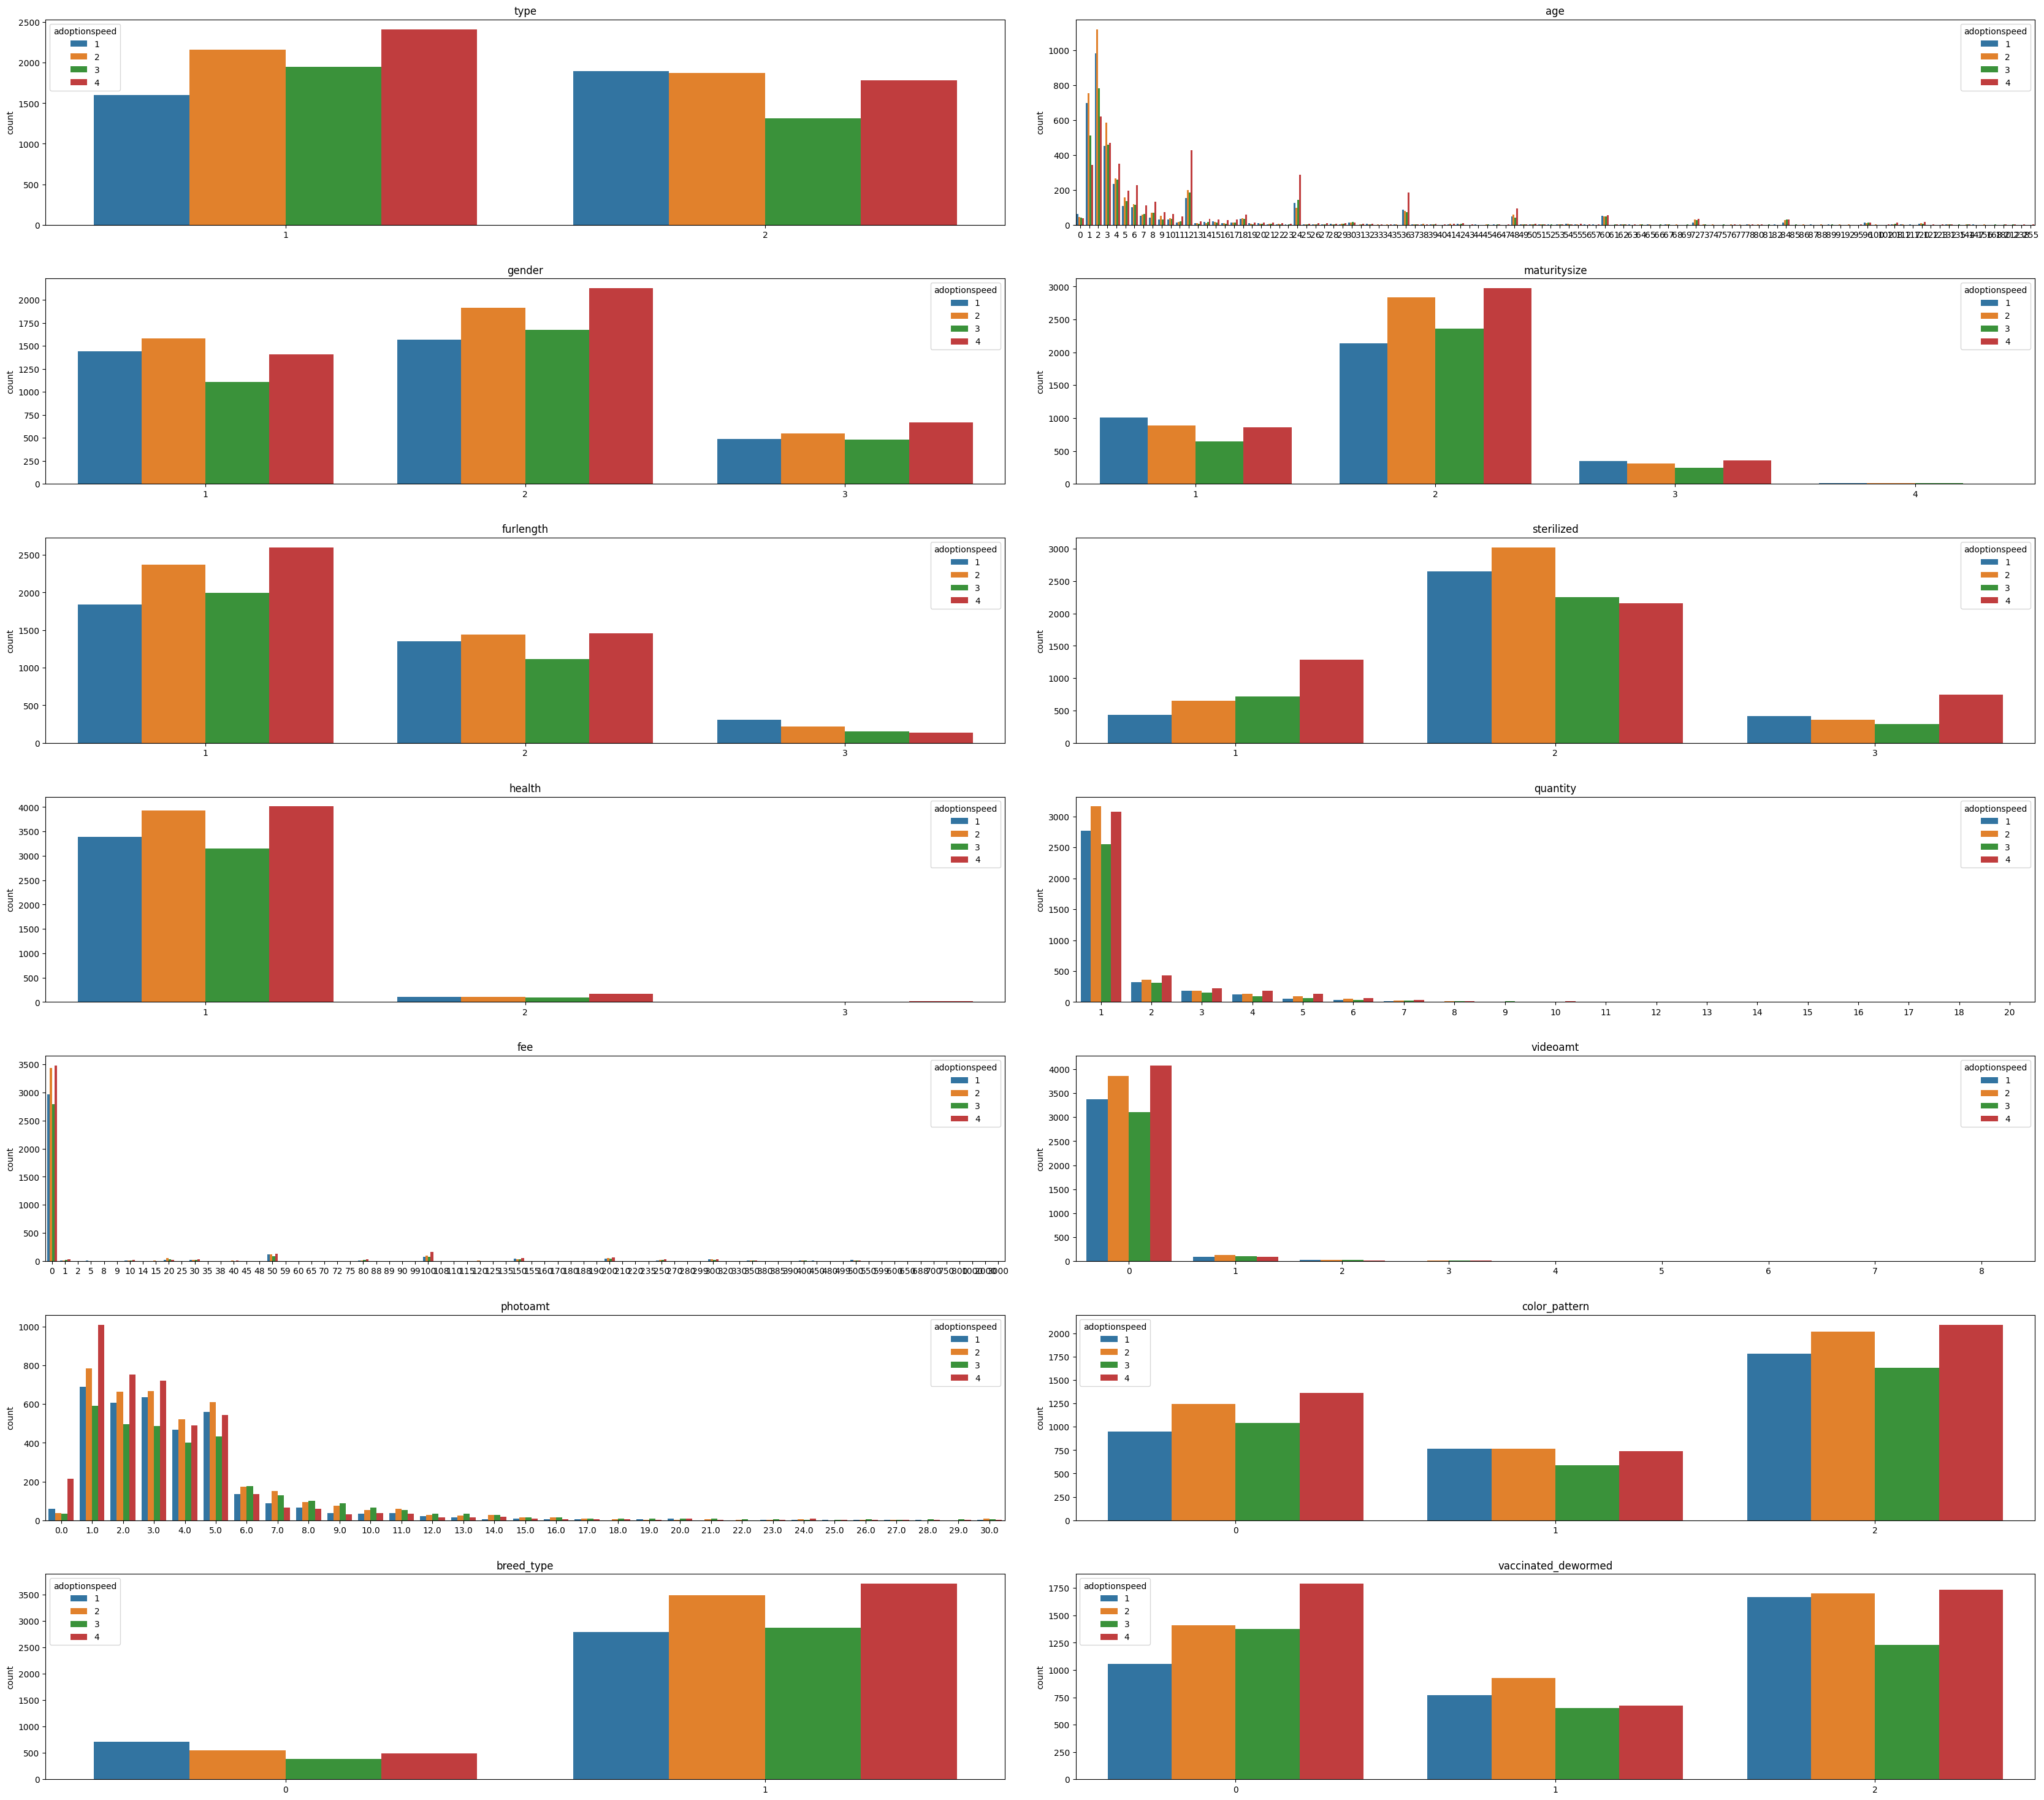

In [231]:
# Plot distribution of features 
features = ['type', 'age', 'gender', 'maturitysize', 'furlength', 'sterilized', 'health', 'quantity', 'fee', 'videoamt', 'photoamt', 'color_pattern', 'breed_type', 'vaccinated_dewormed']

fig,ax = plt.subplots(7,2,figsize=(34,30))
count = 0
for item in features:
    sns.countplot(df_dropped, x=item, ax=ax[int(count/2)][count%2], hue='adoptionspeed').set(title=item, xlabel='')#color='#33658A', kde=True
    count += 1
#ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

#fig.savefig('images/feature_histogram.jpg')

In [232]:
df_dropped.videoamt.value_counts()

videoamt
0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: count, dtype: int64

In [233]:
#pd.crosstab(df_dropped["videoamt"], df_dropped["adoptionspeed"],normalize="index")

In [234]:
# drop video column: hardly any animals with videos, from above crosstab/count plot: for those with video all adoption speeds apparent
df_dropped.drop(["videoamt","color1", "color2", "color3","breed1","breed2", "vaccinated", "dewormed"], axis=1, inplace=True)

In [235]:
# bin fee 0 = no, 1 = yes
# hardly any animals with a fee, binned together
df_dropped["fee_bin"] = np.where((df_dropped["fee"] == 0), 0, 1)


In [236]:
df_dropped.fee_bin.value_counts()

fee_bin
0    12663
1     2330
Name: count, dtype: int64

In [237]:
# bin age feature:
# cats sterilized at around 4 months old, dogs >= 6 months
# newborn: 0-3 months higher adoption speeds up to this age on average (0)
# puppy/kitten 4-12 (1)
# adult 13-72 month (2)
# senior: >= 73 (3)

# create a list of our conditions
conditions_age = [
    ((df_dropped['age'] >= 0) & (df_dropped['age'] <= 3)),
    ((df_dropped['age'] >= 4) & (df_dropped['age'] <= 12)),
    ((df_dropped['age'] >= 13) & (df_dropped['age'] <= 72)),
    (df_dropped['age'] >= 73)
    ]

# create a list of the values we want to assign for each condition
values_age = [0, 1, 2, 3]

# create a new column and use np.select to assign values to it using our lists as arguments
df_dropped['age_bin'] = np.select(conditions_age, values_age)

In [238]:
df_dropped.age_bin.value_counts()

age_bin
0    7952
1    4259
2    2518
3     264
Name: count, dtype: int64

<Axes: xlabel='age_bin', ylabel='count'>

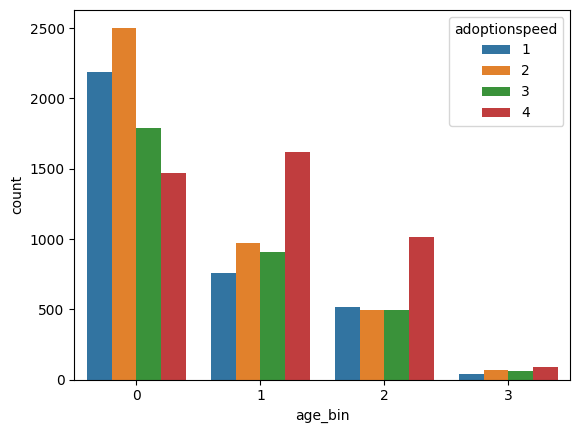

In [239]:
sns.countplot(df_dropped, x="age_bin", hue='adoptionspeed')


In [240]:
df_dropped.drop(["age","fee"], axis=1, inplace=True) #dropping age and fee column because new binned column was created

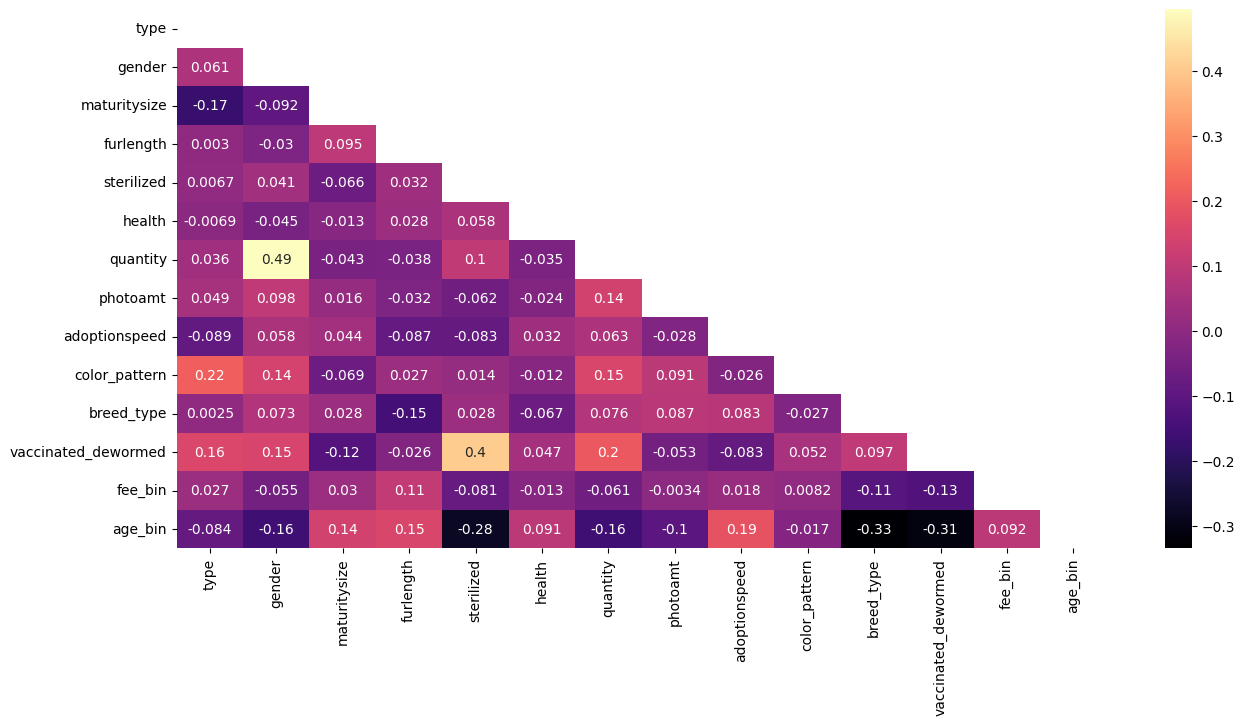

In [241]:
features = df_dropped.columns.tolist()
features.remove("description")

corr_matrix = df_dropped[features].corr()

# creating mask
mask = np.triu(np.ones_like(corr_matrix.corr()))
# plotting a triangle correlation heatmap

plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, annot=True ,cmap="magma", mask=mask)
plt.show()

In [242]:
pd.crosstab(df_dropped["photoamt"], df_dropped["adoptionspeed"],normalize="index")

adoptionspeed,1,2,3,4
photoamt,,,,
0.0,0.170088,0.105572,0.099707,0.624633
1.0,0.224390,0.254634,0.192520,0.328455
2.0,0.240667,0.264098,0.196982,0.298253
3.0,0.253286,0.265233,0.193947,0.287535
4.0,0.249335,0.276449,0.213716,0.260500
...,...,...,...,...
26.0,0.100000,0.200000,0.500000,0.200000
27.0,0.333333,0.166667,0.333333,0.166667
28.0,0.142857,0.000000,0.714286,0.142857


<Axes: xlabel='photoamt'>

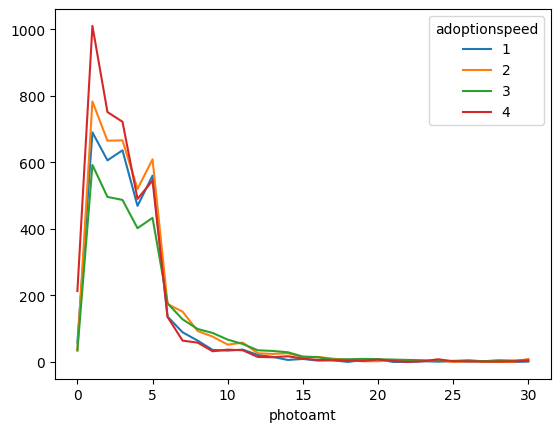

In [243]:
pd.crosstab(df_dropped["photoamt"], df_dropped["adoptionspeed"]#,normalize="index"
).plot.line()

[Text(0.5, 1.0, 'Sterilization for age_bin >=1')]

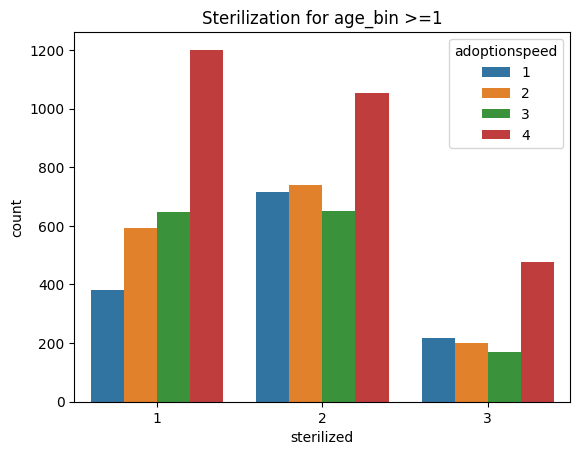

In [244]:
# what about age bin >=1 (i.e., old enough to be sterilized) and sterilization?
sns.countplot(df_dropped.query("age_bin != 0"), x="sterilized", hue='adoptionspeed').set(title="Sterilization for age_bin >=1")
# it does not matter that much whether animals are sterilized or not

[Text(0.5, 1.0, 'Sterilization for age_bin =0')]

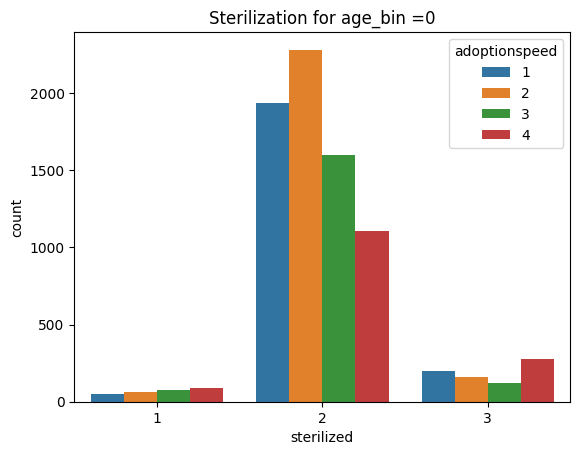

In [245]:
# what about age bin >=1 (i.e., old enough to be sterilized) and sterilization?
sns.countplot(df_dropped.query("age_bin == 0"), x="sterilized", hue='adoptionspeed').set(title="Sterilization for age_bin =0")
# it does not matter if puppies/kittens are sterilized or not

In [246]:
df_dropped.query("photoamt >10").adoptionspeed.value_counts().sum()/df_dropped.shape[0]

0.04882278396585073

In [247]:
# bin photoamt >10 to 11 to get rid of tail
df_dropped["photoamt_11"] = np.where((df_dropped["photoamt"] < 11), df_dropped["photoamt"], 11)

In [248]:
df_dropped.photoamt_11.value_counts()

photoamt_11
1.0     3075
2.0     2518
3.0     2511
5.0     2147
4.0     1881
        ... 
7.0      432
0.0      341
8.0      314
9.0      231
10.0     190
Name: count, Length: 12, dtype: int64

<Axes: xlabel='photoamt_11'>

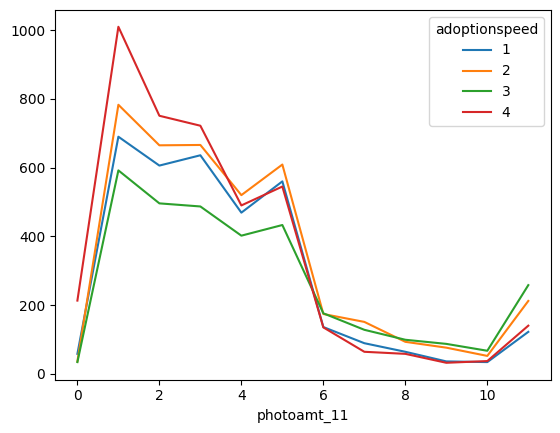

In [249]:
pd.crosstab(df_dropped["photoamt_11"], df_dropped["adoptionspeed"]#,normalize="index"
).plot.line()

## Recommendation to increase Adoption Speed

* Add pictures, ideally $\geq 4$ (starting from that amount, Adoption speed 4 is not the largest subset anymore)

# Feature Description Length
to utilize the description column, we will create a feature holding the length of the description string, the hypothesis being
that animals with a more detailed description will be adopted faster. 

In [250]:
#check where description col. contains missing values
(df_dropped[df_dropped['description'].isnull()])

,type,gender,maturitysize,furlength,sterilized,health,quantity,description,photoamt,adoptionspeed,color_pattern,breed_type,vaccinated_dewormed,fee_bin,age_bin,photoamt_11
96,2,2,3,3,2,1,1,NaN,3.0,1,0,0,0,0,2,3.0
605,2,1,2,2,2,1,1,NaN,3.0,4,2,1,2,0,0,3.0
1098,2,1,1,1,3,1,1,NaN,1.0,4,0,1,0,0,1,1.0
2109,1,2,2,2,1,1,2,NaN,3.0,2,2,1,0,0,2,3.0
4218,2,1,3,1,1,1,1,NaN,5.0,2,1,1,0,0,3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272,1,1,2,2,3,2,1,NaN,0.0,4,1,1,2,0,0,0.0
11365,2,1,3,1,1,1,1,NaN,1.0,2,0,0,0,0,2,1.0
11890,1,2,2,1,2,1,2,NaN,1.0,4,0,1,2,0,0,1.0
12713,1,1,3,2,1,1,1,NaN,4.0,1,1,0,0,1,1,4.0


In [251]:
# create feature of description length (character count)
df_dropped['description_char'] = df_dropped.description.str.len()

#check if this worked
df_dropped.description_char.value_counts()

description_char
12.0      207
14.0       75
122.0      65
16.0       63
88.0       59
         ... 
1376.0      1
1227.0      1
1723.0      1
2119.0      1
1447.0      1
Name: count, Length: 1478, dtype: int64

In [252]:
# the new feature should have same amount of NaN

(df_dropped[df_dropped['description_char'].isnull()])

,type,gender,maturitysize,furlength,sterilized,health,quantity,description,photoamt,adoptionspeed,color_pattern,breed_type,vaccinated_dewormed,fee_bin,age_bin,photoamt_11,description_char
96,2,2,3,3,2,1,1,NaN,3.0,1,0,0,0,0,2,3.0,NaN
605,2,1,2,2,2,1,1,NaN,3.0,4,2,1,2,0,0,3.0,NaN
1098,2,1,1,1,3,1,1,NaN,1.0,4,0,1,0,0,1,1.0,NaN
2109,1,2,2,2,1,1,2,NaN,3.0,2,2,1,0,0,2,3.0,NaN
4218,2,1,3,1,1,1,1,NaN,5.0,2,1,1,0,0,3,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272,1,1,2,2,3,2,1,NaN,0.0,4,1,1,2,0,0,0.0,NaN
11365,2,1,3,1,1,1,1,NaN,1.0,2,0,0,0,0,2,1.0,NaN
11890,1,2,2,1,2,1,2,NaN,1.0,4,0,1,2,0,0,1.0,NaN
12713,1,1,3,2,1,1,1,NaN,4.0,1,1,0,0,1,1,4.0,NaN


In [253]:
# fill missing char count with 0
df_dropped['description_char'] = df_dropped['description_char'].fillna(0)

In [254]:
# create feature of description length (word count)
df_dropped['description_words'] = df_dropped.description.str.count(' ')+1

#check if this worked
df_dropped.description_words.value_counts()

description_words
3.0      291
2.0      266
21.0     251
15.0     203
22.0     198
        ... 
410.0      1
331.0      1
505.0      1
384.0      1
370.0      1
Name: count, Length: 434, dtype: int64

In [255]:
# fill missing word count with 0
df_dropped['description_words'] = df_dropped['description_words'].fillna(0)

<Axes: xlabel='description_words', ylabel='Count'>

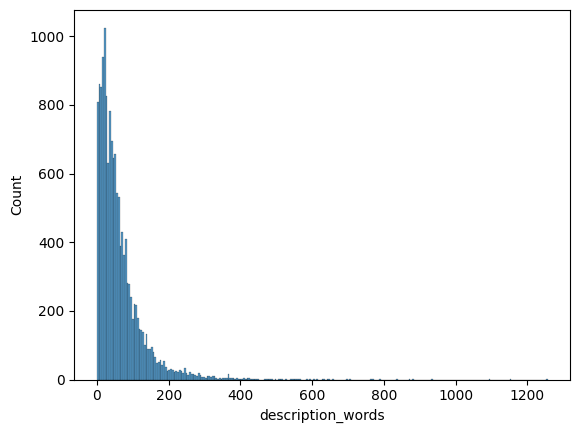

In [256]:
sns.histplot(data=df_dropped, x='description_words')

In [257]:
#sns.histplot(data=df_dropped, x='description_len')

the distribution is extremely skewed and something must be done with it

In [258]:
#sns.catplot(data=df_dropped, x='adoptionspeed', y='description_len', jitter=0.2)

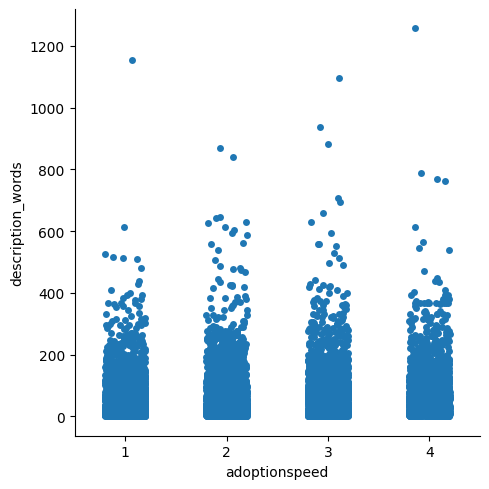

In [259]:
sns.catplot(data=df_dropped, x='adoptionspeed', y='description_words', jitter=0.2)

In [260]:
# drop description column
#df_dropped.drop(['description'], inplace=True, axis=1)

the description length does not seem to influence the adoption speed

In [261]:
# plot the heatmap with final features:

#features3 = df_dropped.columns.tolist()

#corr_matrix = df_dropped[features3].corr()

# creating mask
#mask = np.triu(np.ones_like(corr_matrix.corr()))
# plotting a triangle correlation heatmap

#plt.figure(figsize=(15,7))
#sns.heatmap(corr_matrix, annot=True ,cmap="magma", mask=mask)
#plt.show()

# How to handle multiple animal listings
some oberservations do not refer to one single animal but a group (assumption: most often one littre, which is supported by the finding that most of these listings have animals in age category 0 or 1 (0-3 months and 4-12 months). Possible strategies:
- drop the listings as faulty data (+ the faulty features of these observations would not influence the model; - we would lose mostly young animals which might introduce an age bias)
- treat these observations as one single animal, introduce another category for misleading features (like mix for colorpattern)
- split from the data and model separately in a later iteration

In [262]:
df_dropped.query("quantity>1").age_bin.value_counts()

age_bin
0    2433
1     665
2     308
3      22
Name: count, dtype: int64

In [263]:
pd.crosstab([df_dropped["quantity"],df_dropped["age_bin"]], df_dropped["adoptionspeed"],normalize="index")

adoptionspeed            1         2         3         4
quantity age_bin                                        
1        0        0.289908  0.329589  0.226853  0.153651
         1        0.187257  0.233166  0.221480  0.358097
         2        0.209502  0.200000  0.201357  0.389140
         3        0.140496  0.264463  0.243802  0.351240
2        0        0.290398  0.286885  0.227166  0.195550
...                    ...       ...       ...       ...
17       0        0.000000  0.666667  0.333333  0.000000
18       0        0.000000  0.000000  0.000000  1.000000
20       0        0.000000  0.000000  0.333333  0.666667
         1        0.000000  1.000000  0.000000  0.000000
         2        0.125000  0.125000  0.000000  0.750000

[47 rows x 4 columns]

In [264]:
# how much data of animals aged 0 and 1 would we lose by dropping the multiple listings?

print(f'we would loose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[0]/df_dropped.age_bin.value_counts().iloc[0]).round(2)} percent of newborns.')
print(f'we would loose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[1]/df_dropped.age_bin.value_counts().iloc[1]).round(2)} percent of kittens/puppies.')
print(f'we would loose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[2]/df_dropped.age_bin.value_counts().iloc[2]).round(2)} percent of adults.')
print(f'we would loose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[3]/df_dropped.age_bin.value_counts().iloc[3]).round(2)} percent of seniors.')


# looking at the percentage, we would loose much more of newborns and puppies and kittens if we dropped multiple listings
# but does their distribution actually differ from the entire data (meaning would dropping them skew the distribution differently then it was before)?

we would loose 0.31 percent of newborns.
we would loose 0.16 percent of kittens/puppies.
we would loose 0.12 percent of adults.
we would loose 0.08 percent of seniors.


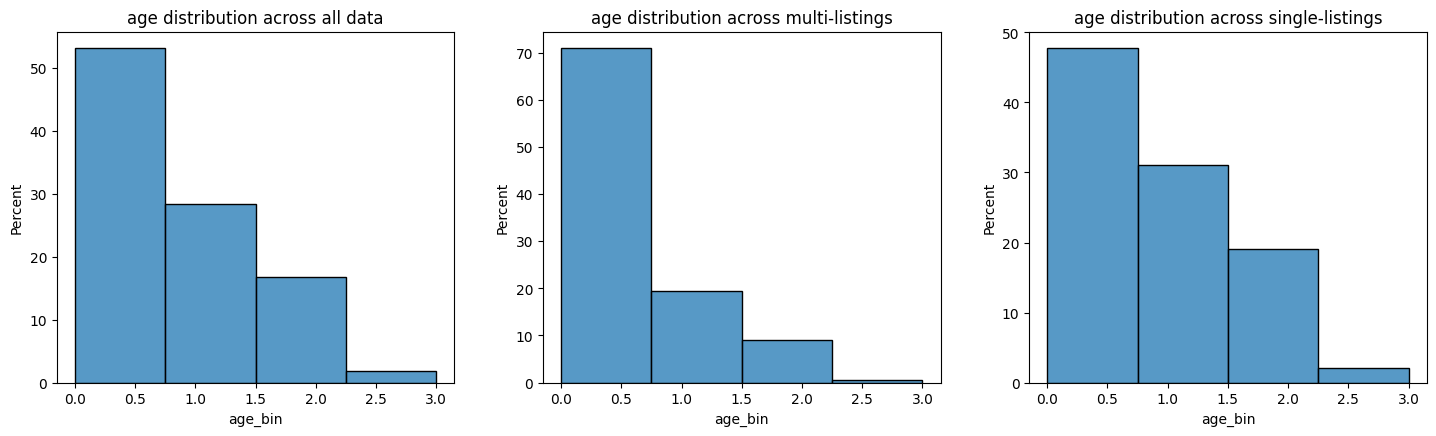

In [265]:
# comparing age distribution in the entire dataset and those we would drop:

fig,ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(ax=ax[0], data=df_dropped, x='age_bin', stat='percent', bins=4)
sns.histplot(ax=ax[1], data=df_dropped.query('quantity > 1'), x='age_bin', stat='percent', bins=4)
sns.histplot(ax=ax[2], data=df_dropped.query('quantity == 1'), x='age_bin', stat='percent', bins=4)
ax[0].set_title('age distribution across all data')
ax[1].set_title('age distribution across multi-listings')
ax[2].set_title('age distribution across single-listings')
fig.tight_layout(pad=3)



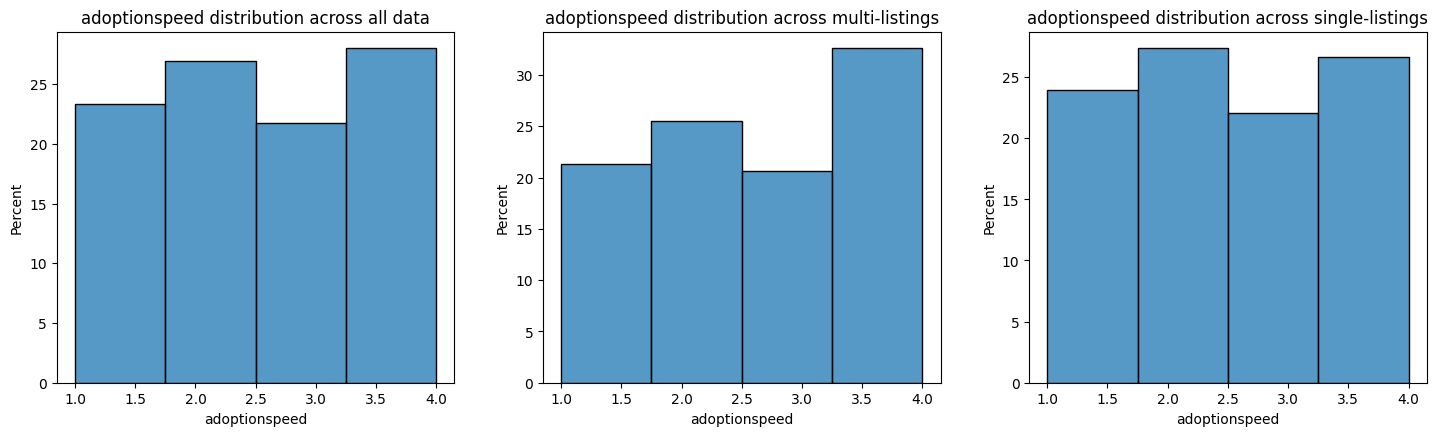

In [266]:
# comparing adoption speed distribution in the entire dataset and those we would drop:

fig,ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(ax=ax[0], data=df_dropped, x='adoptionspeed', stat='percent', bins=4)
sns.histplot(ax=ax[1], data=df_dropped.query('quantity > 1'), x='adoptionspeed', stat='percent', bins=4)
sns.histplot(ax=ax[2], data=df_dropped.query('quantity == 1'), x='adoptionspeed', stat='percent', bins=4)
ax[0].set_title('adoptionspeed distribution across all data')
ax[1].set_title('adoptionspeed distribution across multi-listings')
ax[2].set_title('adoptionspeed distribution across single-listings')
fig.tight_layout(pad=3)

In [267]:
pd.crosstab(df_dropped.quantity, df_dropped.adoptionspeed, normalize='index')

adoptionspeed,1,2,3,4
quantity,,,,
1,0.239516,0.273498,0.220666,0.266321
2,0.228551,0.254571,0.215893,0.300985
3,0.245179,0.249311,0.203857,0.301653
4,0.224105,0.242938,0.182674,0.350282
5,0.147147,0.270270,0.195195,0.387387
...,...,...,...,...
15,0.250000,0.000000,0.250000,0.500000
16,0.000000,0.666667,0.000000,0.333333
17,0.000000,0.666667,0.333333,0.000000


In [268]:
pd.crosstab([df_dropped.quantity, df_dropped.age_bin], df_dropped.adoptionspeed, normalize='index')

adoptionspeed            1         2         3         4
quantity age_bin                                        
1        0        0.289908  0.329589  0.226853  0.153651
         1        0.187257  0.233166  0.221480  0.358097
         2        0.209502  0.200000  0.201357  0.389140
         3        0.140496  0.264463  0.243802  0.351240
2        0        0.290398  0.286885  0.227166  0.195550
...                    ...       ...       ...       ...
17       0        0.000000  0.666667  0.333333  0.000000
18       0        0.000000  0.000000  0.000000  1.000000
20       0        0.000000  0.000000  0.333333  0.666667
         1        0.000000  1.000000  0.000000  0.000000
         2        0.125000  0.125000  0.000000  0.750000

[47 rows x 4 columns]

In [269]:
df_dropped.query('quantity > 1').adoptionspeed.value_counts()

adoptionspeed
4    1117
2     874
1     730
3     707
Name: count, dtype: int64

## Baseline Model

We decided on a decision tree with a limited number of features as a baseline model. 

Features considered:

* age_bin
* photo_11
* breed_type
* type
* color_pattern

"young animals that are pure bred and of a light color pattern listed with photos are adopted fastest"

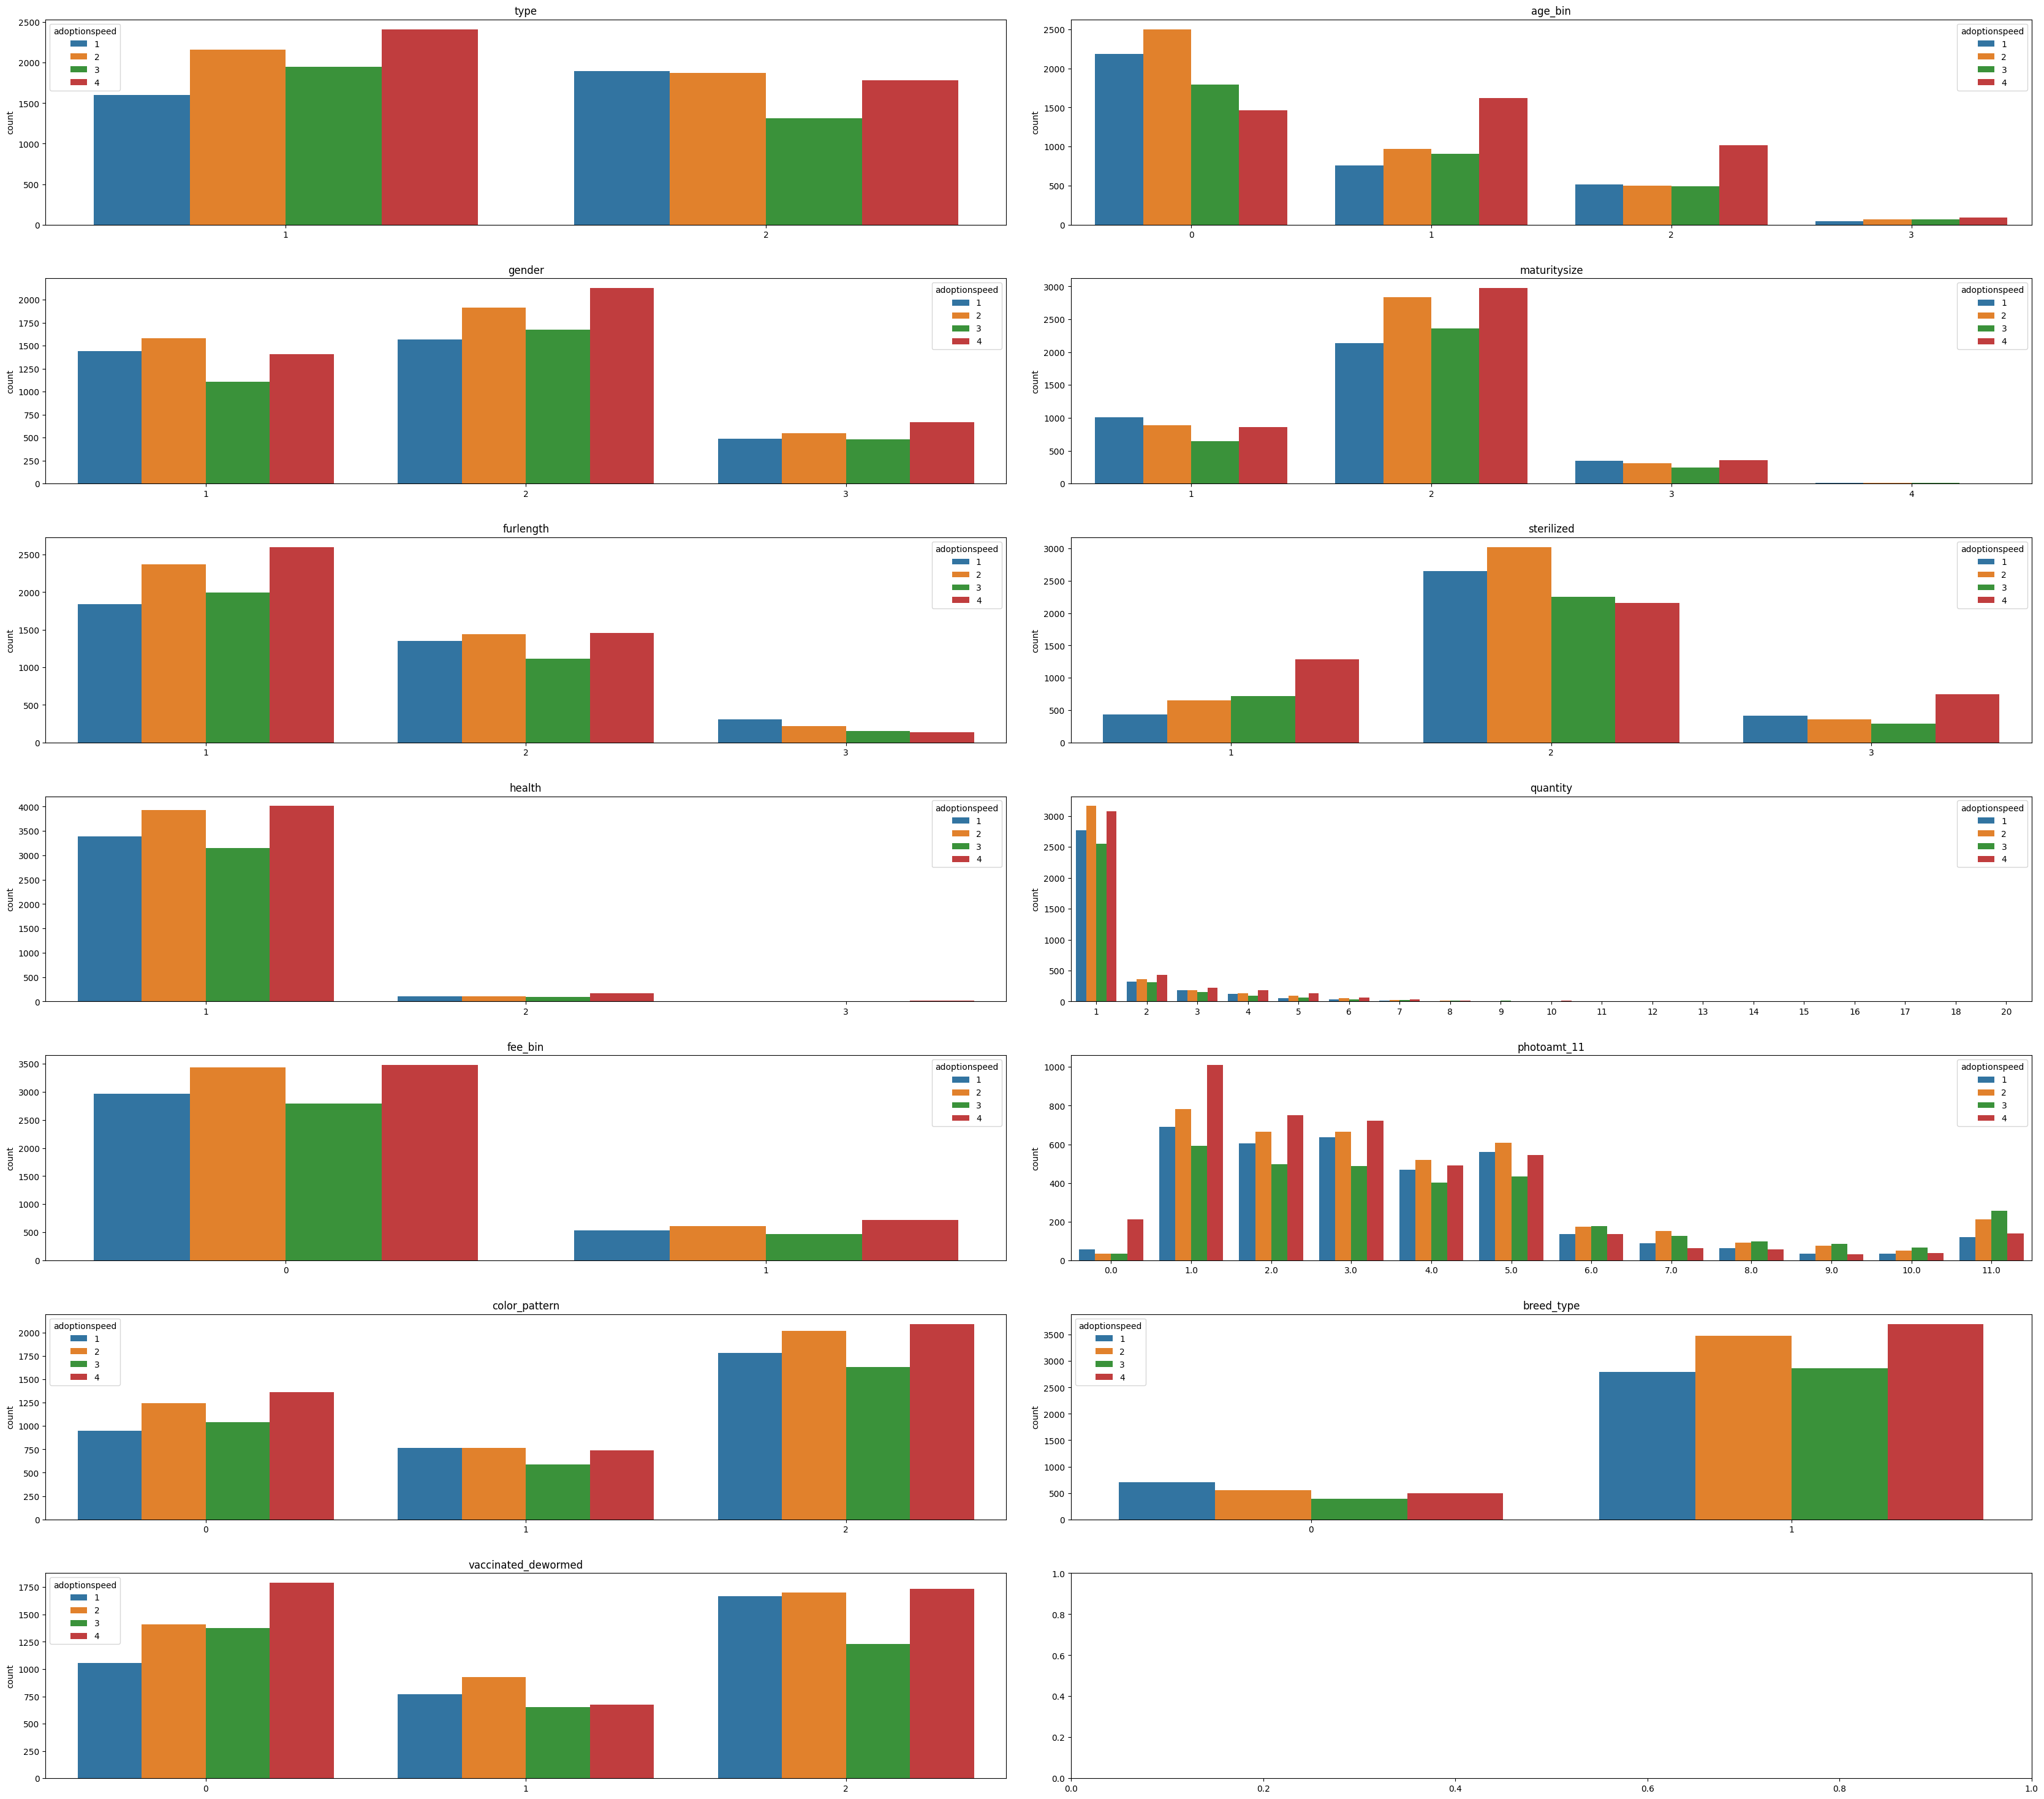

In [270]:
# Plot distribution of features 
features2 = ['type', 'age_bin', 'gender', 'maturitysize', 'furlength', 'sterilized', 'health', 'quantity', 'fee_bin', 'photoamt_11', 'color_pattern', 'breed_type', 'vaccinated_dewormed']

fig,ax = plt.subplots(7,2,figsize=(34,30))
count = 0
for item in features2:
    sns.countplot(df_dropped, x=item, ax=ax[int(count/2)][count%2], hue='adoptionspeed').set(title=item, xlabel='')#color='#33658A', kde=True
    count += 1
#ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

#fig.savefig('../images/feature_histogram2.jpg')

# Baseline moved to the bottom after final cleaning and dummy creation.

# Dummies for different models

- type: change type to 0,1 (substract 1)
- gender: change gender to 0,1 (substract 1),
- maturitry size: ordinal, substract 1, get dummy according to your model
- fur length: ordinal, substract 1, get dummy according to your model
- sterilization: replace unknown (3) with 2 (no), substract 1
- health: ordinal, substract 1, get dummy according to your model
- quantity: rescale
- description: drop for MVP
- photoamt: drop 
- colorpattern: get dummies 
- breed type: done
- vaccinated_dewormed: could be ordinal if you really want it to :)
- fee_bin: done
- age_bin: ordinal, rescale for distance-based models
- photoamt_11: ordinal, rescale
- description_len: drop
- description_char/description_words: ordinal, rescale if you want to include in model 


In [271]:
# change the type column to 0 and 1
df_dropped['type'] = df_dropped['type'] - 1

In [272]:
# change gender to 0, 1,2 from 1, 2, 3 
df_dropped['gender'] = df_dropped['gender'] - 1

In [273]:
# change the maturity size
df_dropped['maturitysize'] = df_dropped['maturitysize'] -1 

In [274]:
# convert the fur size
df_dropped['furlength'] = df_dropped['furlength'] -1 

In [275]:
# convert the health to 0,1,2
df_dropped['health'] = df_dropped['health'] -1 

In [276]:
# replace the 3 which is unknown with no
df_dropped['sterilized'] = df_dropped['sterilized'].replace(3,2)

In [277]:
# convert the sterilized to 0,1
df_dropped['sterilized'] = df_dropped['sterilized'] - 1

In [278]:
# drop columns that we donot need in the models
df_dropped = df_dropped.drop(['photoamt', 'description', 'description_words'], axis=1, errors='ignore')

# Delete quantity > 1 and delete the column

In [279]:
df_dropped = df_dropped[df_dropped["quantity"]==1]

In [280]:
df_dropped = df_dropped.drop("quantity", axis=1)

# Create dummies and scale

In [281]:
# dummies for some columns: maturity size, fur length, health, color_pattern (first column is not dropped from the dummies)

dummy_list = ['maturitysize', 'furlength', 'health', 'color_pattern']

df_dummies = pd.get_dummies(df_dropped[dummy_list], columns=dummy_list, dtype=int)


In [282]:
# first dummy column dropped for the distance based algorithms
df_dummies_distance = pd.get_dummies(df_dropped[dummy_list], columns=dummy_list, dtype=int, drop_first=True)
# create the dataframe with the dropped first dummy column
df_processed_dropped_first =  pd.concat([df_dropped.drop(dummy_list,axis=1), df_dummies_distance],axis=1)

In [283]:
#processed dataframe with dummy columns where first column was not dropped
df_processed =  pd.concat([df_dropped.drop(dummy_list,axis=1), df_dummies],axis=1)


In [284]:
# define X with processed data that still has the all the dummy columns
X_processed = df_processed.drop('adoptionspeed', axis=1)


In [285]:
# define X with data that has the first dummy column dropped
X_dropped_first = df_processed_dropped_first.drop('adoptionspeed', axis=1)

In [286]:
#train test split with X_processed
y = df_processed["adoptionspeed"]
X_train_processed, X_test_processed, y_train, y_test = train_test_split(X_processed, y, random_state=42, stratify=y)

In [287]:
# train test split with the dataframe that has first dummy column removed
X_train_dropped_first, X_test_dropped_first, y_train, y_test = train_test_split(X_dropped_first, y, random_state=42, stratify=y)

In [288]:
minmax_scaler = MinMaxScaler()
# scaled the 4 features 
num_features = ['photoamt_11', 'age_bin', 'description_char']
#scaling with the processed data with all dummy columns
X_train_minmax_scaled_processed_1 = minmax_scaler.fit_transform(X_train_processed[num_features])
X_test_minmax_scaled_processed_1 = minmax_scaler.transform(X_test_processed[num_features])

X_train_minmax_scaled_processed = pd.concat([X_train_processed.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_minmax_scaled_processed_1,columns= num_features)],axis=1)
X_test_minmax_scaled_processed = pd.concat([X_test_processed.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_minmax_scaled_processed_1,columns= num_features)],axis=1)

In [289]:
# scaling the processed data with first dummy column removed
X_train_minmax_scaled_dropped_first_1 = minmax_scaler.fit_transform(X_train_dropped_first[num_features])
X_test_minmax_scaled_dropped_first_1 = minmax_scaler.transform(X_test_dropped_first[num_features])

X_train_minmax_scaled_dropped_first = pd.concat([X_train_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_minmax_scaled_dropped_first_1,columns= num_features)],axis=1)
X_test_minmax_scaled_dropped_first = pd.concat([X_test_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_minmax_scaled_dropped_first_1,columns= num_features)],axis=1)

In [290]:
X_train_minmax_scaled_dropped_first

,type,gender,sterilized,breed_type,vaccinated_dewormed,fee_bin,maturitysize_1,maturitysize_2,maturitysize_3,furlength_1,furlength_2,health_1,health_2,color_pattern_1,color_pattern_2,photoamt_11,age_bin,description_char
0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0.090909,1.000000,0.056573
1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0.454545,0.000000,0.057623
2,0,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0.181818,0.333333,0.077581
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.363636,0.333333,0.086134
4,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0.090909,0.000000,0.001801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8668,0,0,1,1,2,0,1,0,0,0,0,0,0,1,0,0.090909,0.000000,0.011255
8669,1,0,1,1,2,0,1,0,0,0,0,0,0,0,1,0.454545,0.000000,0.021309
8670,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0.090909,0.333333,0.008103
8671,1,1,1,1,2,0,0,1,0,0,0,0,0,0,1,0.454545,0.666667,0.069328


# Export Processed Data 

In [291]:
# export processed data set to csv

# export features for tree-based models
pd.DataFrame(X_train_minmax_scaled_processed).to_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv', index=False)
pd.DataFrame(X_test_minmax_scaled_processed).to_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv', index=False)

# export features for distance-based models
pd.DataFrame(X_train_minmax_scaled_dropped_first).to_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_dropped_first.csv', index=False)
pd.DataFrame(X_test_minmax_scaled_dropped_first).to_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_dropped_first.csv', index=False)

# export target
pd.DataFrame(y_train).to_csv('../data/petfinder-adoption-prediction/train/y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('../data/petfinder-adoption-prediction/train/y_test.csv', index=False)


# Create separate cat dog dataframe before traintest split

In [292]:
df_dogs = df_dropped[df_dropped["type"]==0].reset_index(drop=True)
df_cats = df_dropped[df_dropped["type"]==1].reset_index(drop=True)

In [293]:
dummy_list = ['gender', 'maturitysize', 'furlength', 'health', 'color_pattern']

# dummies for dogs with first column not dropped
df_dog_dummies = pd.get_dummies(df_dogs[dummy_list], columns=dummy_list, dtype=int)
df_dogs_dummies_not_dropped =  pd.concat([df_dogs.drop(dummy_list,axis=1), df_dog_dummies],axis=1)

#dummies for dogs with first column dropped
df_dog_dummies_first = pd.get_dummies(df_dogs[dummy_list], columns=dummy_list, dtype=int, drop_first=True)
df_dogs_dropped_first =  pd.concat([df_dogs.drop(dummy_list,axis=1), df_dog_dummies_first],axis=1)

#dummies for cats with first column not dropped
df_cat_dummies = pd.get_dummies(df_cats[dummy_list], columns=dummy_list, dtype=int)
df_cats_dummies_not_dropped =  pd.concat([df_cats.drop(dummy_list,axis=1), df_cat_dummies],axis=1)

#dummies for cats with first column dropped
df_cat_dummies_first = pd.get_dummies(df_cats[dummy_list], columns=dummy_list, dtype=int, drop_first=True)
df_cats_dropped_first =  pd.concat([df_cats.drop(dummy_list,axis=1), df_cat_dummies_first],axis=1)

In [294]:
#train test split for the dataframe with not dropped dummy column for dogs
X_dogs_not_dropped = df_dogs_dummies_not_dropped.drop('adoptionspeed', axis=1)
y_dogs = df_dogs["adoptionspeed"]
X_train_dogs_not_dropped, X_test_dogs_not_dropped, y_train_dogs, y_test_dogs = train_test_split(X_dogs_not_dropped, y_dogs, random_state=42, stratify=y_dogs)

In [295]:
#train test split for the dataframe with dropped dummy column for dogs
X_dogs_dropped_first = df_dogs_dropped_first.drop('adoptionspeed', axis=1)
y_dogs = df_dogs["adoptionspeed"]
X_train_dogs_dropped_first, X_test_dogs_dropped_first, y_train_dogs, y_test_dogs = train_test_split(X_dogs_dropped_first, y_dogs, random_state=42, stratify=y_dogs)

In [296]:
#train test split for the dataframe with not dropped column for cats
X_cats_not_dropped = df_cats_dummies_not_dropped.drop('adoptionspeed', axis=1)
y_cats = df_cats["adoptionspeed"]
X_train_cats_not_dropped, X_test_cats_not_dropped, y_train_cats, y_test_cats = train_test_split(X_cats_not_dropped, y_cats, random_state=42, stratify=y_cats)

In [297]:
#train test split for the dataframe with dropped column for cats
X_cats_dropped_first = df_cats_dropped_first.drop('adoptionspeed', axis=1)
y_cats = df_cats["adoptionspeed"]
X_train_cats_dropped_first, X_test_cats_dropped_first, y_train_cats, y_test_cats = train_test_split(X_cats_dropped_first, y_cats, random_state=42, stratify=y_cats)

In [298]:
minmax_scaler = MinMaxScaler()
# scaled the 4 features 
num_features = ['photoamt_11', 'age_bin', 'description_char']
#scaling with the processed data with all dummy columns
X_train_dogs_sc = minmax_scaler.fit_transform(X_train_dogs_not_dropped[num_features])
X_test_dogs_sc = minmax_scaler.transform(X_test_dogs_not_dropped[num_features])
#scaling for the data with first dropped dummy column
X_train_dogs_dropped_sc = minmax_scaler.fit_transform(X_train_dogs_dropped_first[num_features])
X_test_dogs_dropped_sc = minmax_scaler.transform(X_test_dogs_dropped_first[num_features])
#concatenate the dataframe for dogs with dummy column not removed
X_train_dogs_all = pd.concat([X_train_dogs_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_dogs_sc,columns= num_features)],axis=1)
X_test_dogs_all = pd.concat([X_test_dogs_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_dogs_sc,columns= num_features)],axis=1)
#concatenate the dataframe for dogs with dummy column removed
X_train_dogs_dropped = pd.concat([X_train_dogs_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_dogs_dropped_sc,columns= num_features)],axis=1)
X_test_dogs_dropped = pd.concat([X_test_dogs_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_dogs_dropped_sc,columns= num_features)],axis=1)

In [299]:
minmax_scaler = MinMaxScaler()
#scaling with the processed data with all dummy columns
X_train_cats_sc = minmax_scaler.fit_transform(X_train_cats_not_dropped[num_features])
X_test_cats_sc = minmax_scaler.transform(X_test_cats_not_dropped[num_features])
#scaling with the processed data with first dummy column removed
X_train_cats_dropped_sc = minmax_scaler.fit_transform(X_train_cats_dropped_first[num_features])
X_test_cats_dropped_sc = minmax_scaler.transform(X_test_cats_dropped_first[num_features])
#concatenate the dataframes with all the columns
X_train_cats_all = pd.concat([X_train_cats_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_cats_sc,columns= num_features)],axis=1)
X_test_cats_all = pd.concat([X_test_cats_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_cats_sc,columns= num_features)],axis=1)
#concatenate the dataframes with the first dummy column removed
X_train_cats_dropped = pd.concat([X_train_cats_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_cats_dropped_sc,columns= num_features)],axis=1)
X_test_cats_dropped = pd.concat([X_test_cats_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_cats_dropped_sc,columns= num_features)],axis=1)

In [300]:
# import os
# #delete the wrong files that were created before. Just run this first and then delete it or comment it out.
# #it just removes the files we dont need
# os.remove('../data/petfinder-adoption-prediction/train/X_test_dogs.csv')
# os.remove('../data/petfinder-adoption-prediction/train/X_train_dogs.csv')
# os.remove('../data/petfinder-adoption-prediction/train/X_test_cats.csv')
# os.remove('../data/petfinder-adoption-prediction/train/X_train_cats.csv')

In [301]:
# export processed data set to csv

# export features for tree-based models (dogs)
pd.DataFrame(X_train_dogs_all).to_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_all.csv', index=False)
pd.DataFrame(X_test_dogs_all).to_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_all.csv', index=False)

# export features for tree-based models (cats)
pd.DataFrame(X_train_cats_all).to_csv('../data/petfinder-adoption-prediction/train/X_train_cats_all.csv', index=False)
pd.DataFrame(X_test_cats_all).to_csv('../data/petfinder-adoption-prediction/train/X_test_cats_all.csv', index=False)

# export features for distance-based models (dogs)
pd.DataFrame(X_train_dogs_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_dropped.csv', index=False)
pd.DataFrame(X_test_dogs_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_dropped.csv', index=False)

# export features for distance-based models (cats)
pd.DataFrame(X_train_cats_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_train_cats_dropped.csv', index=False)
pd.DataFrame(X_test_cats_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_test_cats_dropped.csv', index=False)

# export target
pd.DataFrame(y_train_dogs).to_csv('../data/petfinder-adoption-prediction/train/y_train_dogs.csv', index=False)
pd.DataFrame(y_test_dogs).to_csv('../data/petfinder-adoption-prediction/train/y_test_dogs.csv', index=False)

pd.DataFrame(y_train_cats).to_csv('../data/petfinder-adoption-prediction/train/y_train_cats.csv', index=False)
pd.DataFrame(y_test_cats).to_csv('../data/petfinder-adoption-prediction/train/y_test_cats.csv', index=False)

# Baseline model:

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3838
_____________________
Weighted Quadratic Kappa: 0.3127


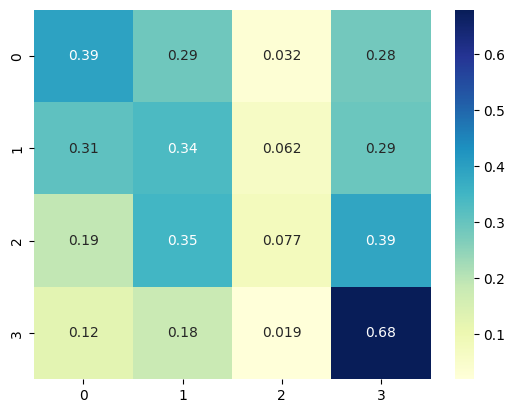

In [302]:
X_baseline = df_processed[["age_bin", "photoamt_11", "breed_type", "type", "color_pattern_0","color_pattern_1","color_pattern_2"]]
y = df_processed["adoptionspeed"]
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_baseline, y, random_state=42, stratify=y)
baseline = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 15)
baseline.fit(X_train_bl, y_train_bl)

y_pred_bl = baseline.predict(X_test_bl)
our_metrics(y_test_bl, y_pred_bl, normalize=True)

# Graphviz commented out:

In [303]:
# fig = plt.figure(figsize=(35,20))
# baseline_plot = plot_tree(baseline, filled=True, fontsize=12, feature_names=["age_bin", "photoamt_11", "breed_type", "type", "color_pattern_0","color_pattern_1","color_pattern_2"], class_names=True)
# plt.savefig('../images/baseline_plot.jpg')

In [304]:
# dot_data = tree.export_graphviz(baseline, out_file=None, feature_names=["age_bin", "photoamt_11", "breed_type", "type", "color_pattern"], class_names=['1','2','3','4'], rounded=True, special_characters=True, filled=True) 
# baseline_plot_2 = graphviz.Source(dot_data)

# baseline_plot_2.render('../images/baseline_plot_2')
# baseline_plot_2